# Mean profile based moa prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../common_.py
import sys
sys.path.append("../..")
from common import *

In [3]:
import pyarrow
from sklearn.decomposition import FactorAnalysis
from sklearn.metrics import ConfusionMatrixDisplay

# Data

In [61]:
try:
    paths = snakemake.input.paths
    labels_path = snakemake.input.labels
except NameError:
    data_root = Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/BBBC021")
    data_dir = data_root / "scip"
    paths = data_dir.rglob("features.parquet")
    labels_path = data_dir.parent / "labels.parquet"
    moa_path = data_root / "BBBC021_v1_moa.csv"

In [62]:
%%time
df = pandas.concat([pq.read_table(p).to_pandas() for p in paths])
df = df.drop(columns=df.filter(regex='meta_image_.*').columns.tolist() + ["meta_replicate", "meta_imagenumber", "meta_tablenumber"])

CPU times: user 10.2 s, sys: 9min 11s, total: 9min 21s
Wall time: 9min 56s


In [63]:
df.columns[df.isna().all()]

Index([], dtype='object')

In [64]:
df = df[~df.isna().any(axis=1)]

In [65]:
labels = pq.read_table(labels_path).to_pandas()

In [70]:
df = df.merge(labels, left_on="meta_filename", right_on="meta_image_filename_dapi", suffixes=("_", ""), how="inner")

In [71]:
df["meta_moa"].unique().shape

(13,)

# Removing interplate variation

In [72]:
qq_dmso = df[df["meta_moa"] == "DMSO"].groupby("meta_image_metadata_plate_dapi")[df.filter(regex="feat").columns].quantile((0.01, 0.99))

In [73]:
dfs = []
for idx, gdf in df.groupby("meta_image_metadata_plate_dapi"):
    print(idx)
    df_scaled = (gdf.filter(regex="feat") - qq_dmso.loc[idx, 0.01]) / (qq_dmso.loc[idx, 0.99] - qq_dmso.loc[idx, 0.01])
    df_scaled = pandas.concat([df_scaled, gdf.filter(regex="meta")], axis=1)
    
    dfs.append(df_scaled)

Week10_40111
Week10_40115
Week10_40119
Week1_22123
Week1_22141
Week1_22161
Week1_22361
Week1_22381
Week1_22401
Week3_25421
Week3_25441
Week3_25461
Week3_25681
Week3_25701
Week3_25721
Week4_27481
Week4_27521
Week4_27542
Week4_27801
Week4_27821
Week4_27861
Week5_28901
Week5_28961
Week5_29301
Week5_29321
Week5_29341
Week6_31641
Week6_31661
Week6_31681
Week6_32061
Week6_32121
Week6_32161
Week7_34341
Week7_34381
Week7_34641
Week7_34661
Week7_34681
Week8_38203
Week8_38221
Week8_38241
Week8_38341
Week8_38342
Week9_39206
Week9_39221
Week9_39222
Week9_39282
Week9_39283
Week9_39301


In [74]:
df = pandas.concat(dfs)
del dfs

In [75]:
df.columns[df.isna().all()]

Index([], dtype='object')

In [76]:
nancols = df.columns[df.isna().any()]
nancols

Index(['feat_euler_number_combined', 'feat_euler_number_DAPI',
       'feat_euler_number_actin', 'feat_euler_number_tubulin'],
      dtype='object')

In [77]:
df = df.drop(columns=nancols)

In [78]:
fa = FactorAnalysis(random_state=0, n_components=50)

In [79]:
%%time
fa.fit(df[df["meta_compound"] == "DMSO"].filter(regex="feat").sample(n=50000))

CPU times: user 36.3 s, sys: 770 ms, total: 37 s
Wall time: 37.5 s


FactorAnalysis(n_components=50)

In [94]:
dfs = []
for idx, gdf in df[df["meta_moa"] != "DMSO"].groupby(["meta_compound", "meta_concentration", "meta_replicate"]):
    tmp_df = pandas.Series(data=fa.transform(gdf.filter(regex="feat")).mean(axis=0))
    tmp_df.index = ["feat_"+str(c) for c in tmp_df.index]
    tmp_df["meta_compound"] = idx[0]
    tmp_df["meta_concentration"] = idx[1]
    tmp_df["meta_replicate"] = idx[2]
    dfs.append(tmp_df)
    
mu = pandas.DataFrame(dfs)

In [95]:
del dfs

In [96]:
mu.shape

(276, 53)

In [ ]:
# mu = df_scaled.groupby(["meta_compound", "meta_concentration", "meta_replicate"])[df_scaled.filter(regex="feat").columns].mean()
# mu.shape

In [99]:
moa = pandas.read_csv(moa_path).set_index(["compound", "concentration"])

In [100]:
treatment_profiles = mu.groupby(["meta_compound", "meta_concentration"]).median()
treatment_profiles.index.names = ["compound", "concentration"]
treatment_profiles = treatment_profiles.merge(moa, left_index=True, right_index=True).reset_index()

# Exploration

<AxesSubplot:xlabel='count', ylabel='moa'>

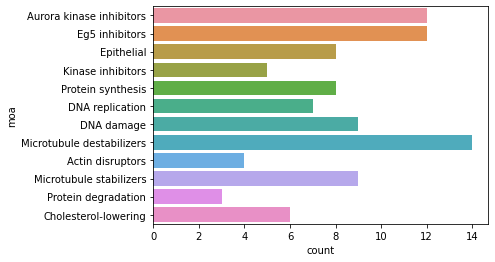

In [101]:
seaborn.countplot(data=treatment_profiles, y="moa")

<AxesSubplot:xlabel='count', ylabel='compound'>

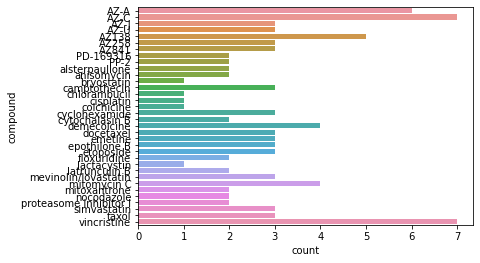

In [102]:
seaborn.countplot(data=treatment_profiles, y="compound")

## dimdred

In [103]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [104]:
dimred = PCA().fit_transform(treatment_profiles.filter(regex="feat"))

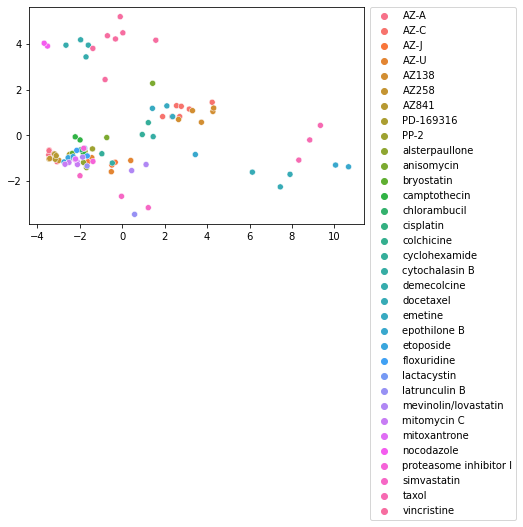

In [105]:
seaborn.scatterplot(x=dimred[:, 0], y=dimred[:, 1], hue=treatment_profiles["compound"])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

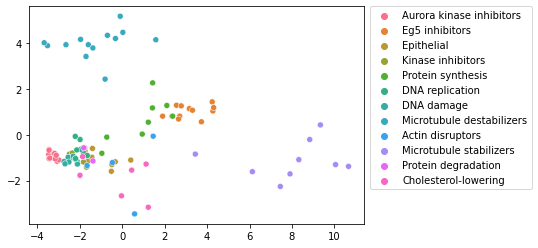

In [106]:
seaborn.scatterplot(x=dimred[:, 0], y=dimred[:, 1], hue=treatment_profiles["moa"])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [107]:
from umap import UMAP

In [108]:
dimred = UMAP(metric="cosine", min_dist=0.5, n_neighbors=8, random_state=0).fit_transform(treatment_profiles.filter(regex="feat"))

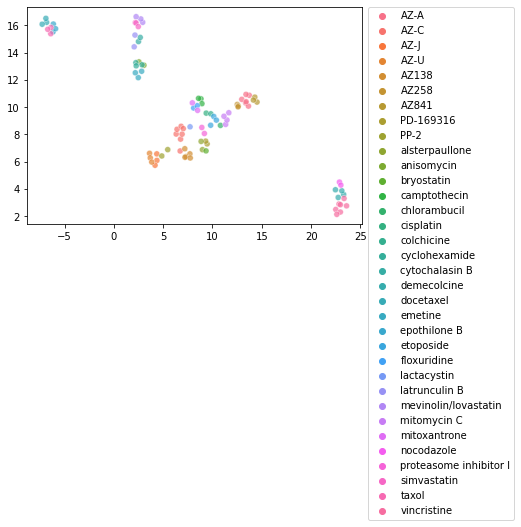

In [109]:
seaborn.scatterplot(x=dimred[:, 0], y=dimred[:, 1], hue=treatment_profiles["compound"], edgecolors="none", alpha=.7)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

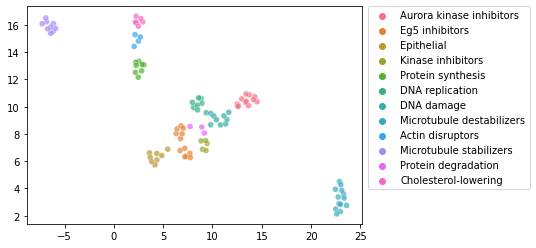

In [110]:
seaborn.scatterplot(x=dimred[:, 0], y=dimred[:, 1], hue=treatment_profiles["moa"], edgecolors="none", alpha=.7)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Prediction

In [111]:
from sklearn.model_selection import LeaveOneGroupOut, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

In [112]:
results = cross_validate(
    cv=LeaveOneGroupOut(),
    X=treatment_profiles.filter(regex="feat"),
    y=treatment_profiles["moa"],
    groups=treatment_profiles["compound"],
    estimator=make_pipeline(
        KNeighborsClassifier(n_neighbors=1, metric="cosine"),
    ),
    return_train_score=True,
    return_estimator=True,
    scoring=("accuracy", "balanced_accuracy", "f1_macro", "precision_macro")
)

/data/gent/420/vsc42015/python_lib_doduo/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/data/gent/420/vsc42015/python_lib_doduo/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/gent/420/vsc42015/python_lib_doduo/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/data/gent/420/vsc42015/python_lib_doduo/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

In [113]:
results["train_accuracy"].mean(), results["train_accuracy"].std()

(1.0, 0.0)

In [114]:
results["test_accuracy"].mean(), results["test_accuracy"].std()

(0.8553921568627451, 0.3242064366005962)

In [115]:
preds = []
true = []
for e, (_, test_index) in zip(
    results["estimator"], 
    LeaveOneGroupOut().split(treatment_profiles.filter(regex="feat"), treatment_profiles["moa"], treatment_profiles["compound"])
):
    pred = e.predict(treatment_profiles.filter(regex="feat").iloc[test_index])
    preds.extend(pred)
    true.extend(treatment_profiles["moa"].iloc[test_index])

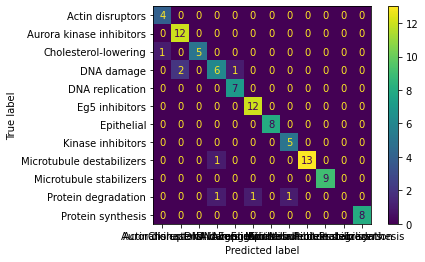

In [116]:
ConfusionMatrixDisplay.from_predictions(true, preds)

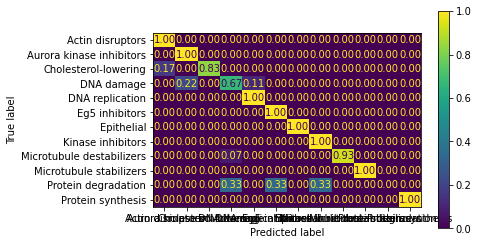

In [122]:
disp = ConfusionMatrixDisplay.from_predictions(true, preds, normalize='true', values_format=".2f")
disp.ax_.set_aspect(0.65)

In [128]:
(df["meta_compound"] + df["meta_concentration"].astype(str)).unique().shape

(98,)